## Autor: Claudio Honorato Junior

Este trabalho faz parte da Monografia apresentada ao Departamento de Ciências de Computação do Instituto de Ciências Matemáticas e de Computação, Universidade de São Paulo - ICMC/USP, como parte dos requisitos para obtenção do título de Especialista em Inteligência Artificial e Big Data.

## Classificação de Objetos Celestes e Espectros Estelares com Perceptron 

Este trabalho propõe o uso de Redes Neurais Multicamadas (MLP) para a classificação de 
objetos astronômicos com base em dados espectroscópicos do Sloan Digital Sky Survey (SDSS). 
A pesquisa aborda três objetivos principais: (i) classificar objetos celestes em estrelas, galáxias 
e quasares; (ii) subclassificar estrelas conforme a classificação espectral de Harvard, com base 
na temperatura superficial. O modelo MLP foi comparado com algoritmos tradicionais como 
SVM, KNN, Regressão Logística, Random Forest e Naive-Bayes, entre outros, avaliando seu desempenho por 
meio de métricas como acurácia, precisão, recall e F1-score. A metodologia incluiu limpeza, 
normalização e seleção de features espectrais, além de técnicas de validação cruzada para 
garantir a robustez dos resultados. Os achados mostram que redes neurais profundas podem 
ser eficazes na análise de espectros astronômicos, oferecendo uma alternativa promissora 
para o tratamento de grandes volumes de dados no contexto da astrofísica moderna.

#### Neste notebook: (i) classificar objetos celestes em estrelas, galáxias e quasares;

## Classification of Celestial Objects and Stellar Spectra with Perceptron

This work proposes the use of Multilayer Neural Networks (MLP) for the classification of 
astronomical objects based on spectroscopic data from the Sloan Digital Sky Survey (SDSS). The 
research addresses three main objectives: (i) to classify celestial objects into stars, galaxies, 
and quasars; (ii) to subclassify stars according to the Harvard spectral classification, based on 
surface temperature. The MLP model was compared with traditional algorithms such as SVM, 
KNN, Logistic Regression, Random Forest, and Naive-Bayes, between others, evaluating its performance 
through metrics such as accuracy, precision, recall, and F1-score. The methodology included 
spectral cleaning, normalization, and feature selection, as well as cross-validation techniques 
to ensure the robustness of the results. The findings show that deep neural networks can be 
effective in the analysis of astronomical spectra, offering a promising alternative for the 
treatment of large volumes of data in the context of modern astrophysics.

#### In this notebook:  (i) to classify celestial objects into stars, galaxies, and quasars;


### NOTEBOOK DE TRATAMENTO E PREPARAÇÃO DOS DADOS
#### O objetivo deste notebook é preparar os dados para serem consumidos pelo segundo notebook chamado "tcc_02_treinamento_ObjetosAstronomicos".


In [0]:
pip install SMOTE imblearn

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from pyspark.sql.functions import when, col, log1p, substring, trim, length
from pyspark.sql import SparkSession
from imblearn.over_sampling import SMOTE

In [0]:
# Codigo para executar no DATABRICKS

# Definir caminhos no DBFS
base_path = "dbfs:/FileStore/classification/astronomical_objects/"
pasta_bronze = f"{base_path}bronze"
pasta_silver = f"{base_path}silver/balanceado"
arquivo_pt1 = "objetos_estelares_Pt1.csv"
arquivo_pt2 = "objetos_estelares_Pt2.csv"
arquivo_tratado = "objetos_estelares_tratado"
arquivo_balanceado = "objetos_estelares_balanceado"

# Criar pastas usando dbutils
try:
    dbutils.fs.mkdirs(pasta_bronze)
    dbutils.fs.mkdirs(pasta_silver)
    print(f"Pastas criadas com sucesso em: {base_path}")
except Exception as e:
    print(f"Erro ao criar pastas: {e}")

# Verificar estrutura criada
print("\nEstrutura de pastas:")
print(f"Bronze: {pasta_bronze}")
print(f"Silver: {pasta_silver}")
print(f"Arquivos esperados: {arquivo_pt1}, {arquivo_pt2}, {arquivo_tratado}, {arquivo_balanceado}")


Pastas criadas com sucesso em: dbfs:/FileStore/classification/astronomical_objects/

Estrutura de pastas:
Bronze: dbfs:/FileStore/classification/astronomical_objects/bronze
Silver: dbfs:/FileStore/classification/astronomical_objects/silver/balanceado
Arquivos esperados: objetos_estelares_Pt1.csv, objetos_estelares_Pt2.csv, objetos_estelares_tratado, objetos_estelares_balanceado


In [0]:
 # Criar SparkSession
spark = SparkSession.builder \
     .appName("TCC") \
     .getOrCreate()

# Lendo arquivos bruto
df_pt1 = spark.read.csv(
    pasta_bronze + "/" + arquivo_pt1,
    header=True,
    inferSchema=True,
)

df_pt2 = spark.read.csv(
    pasta_bronze + "/" + arquivo_pt2,
    header=True,
    inferSchema=True,
)

# Unindo os 2 arquivos em 1 dataFrame consolidado
df_total = df_pt1.union(df_pt2) # colunas e ordem iguais

In [0]:
print(df_pt1.count())
print(df_pt2.count())
print(df_total.count())

500000
500000
1000000


In [0]:
# Salvando em dataframe temporario
df_total.createOrReplaceTempView("temp_objects_all")

# Selecionando apenas as colunas necessárias
# Nota: As colunas que foram eliminadas são os metadados dos espectros
df_stars = spark.sql(

    """
    SELECT *
    FROM temp_objects_all
    """
)

display(df_stars.limit(5))

objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
1237663478721807796,333.1101,-0.4156123,23.68024,22.93109,22.38346,21.54711,21.80262,4192,301,3,176,1.039999E19,GALAXY,0.912237,9237,58022,202
1237650370484306247,185.3537,-2.581337,20.71064,20.22823,19.8522,19.59367,19.34152,1140,301,3,217,4.25255E18,QSO,2.875383,3777,55210,96
1237650370473951390,161.7517,-2.308346,24.64835,22.00048,21.63793,21.72727,22.06267,1140,301,3,59,4.262744E18,QSO,3.892739,3786,55563,316
1237662341093000137,253.5217,19.05752,21.94553,21.44538,19.54981,18.87251,18.44153,3927,301,4,186,4.705149E18,GALAXY,0.3766502,4179,55684,50
1237660961326432940,132.8209,30.8732,23.83978,22.87262,20.98026,19.61335,18.91918,3606,301,2,59,5.837809E18,GALAXY,0.7165546,5185,55978,63


In [0]:
# df_stars = df_stars.withColumn(
#     "subclass",
#     when(
#         (length(trim(col("subclass"))) <= 4), # Agrupando as classes que tem 4 letras ou menos
#         substring(trim(col("subclass")), 1, 1),
#     ).otherwise(trim(col("subclass")))
# )

# # Agrupa e ordena do mais frequente para o menos frequente
# df_stars.groupBy("subclass").count().orderBy("count", ascending=False).show()


In [0]:
# Astrônomos frequentemente usam índices de cor como u-g, g-r, r-i, i-z, que representam a diferença de magnitude entre bandas. 
# Essas diferenças estão associadas à temperatura e composição da estrela.

# 1. Diferenças de Magnitudes (Cores)
# Aplicando regra de "índices de cor"
df = df_stars.withColumn("u_g", col("u") - col("g")) \
             .withColumn("g_r", col("g") - col("r")) \
             .withColumn("r_i", col("r") - col("i")) \
             .withColumn("i_z", col("i") - col("z"))

In [0]:
df.count()

1000000

In [0]:
df_pd = df.toPandas()

df_pd.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid,u_g,g_r,r_i,i_z
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.237668e+18,163.988444,20.216662,21.557787,20.140091,19.267326,18.656588,18.311960,5288.795266,301.0,3.316084,179.121561,5.795723e+18,0.571702,5147.527242,55622.171717,445.856001,1.417696,0.872765,0.610738,0.344628
std,8.511905e+12,104.275382,19.604599,70.894225,69.447619,60.969422,64.947858,67.223533,1981.830741,0.0,1.620920,136.933071,3.360872e+18,0.726588,2985.036730,1812.453364,273.328062,14.218792,33.232370,22.401601,26.502114
min,1.237646e+18,0.000095,-19.702720,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,109.000000,301.0,1.000000,11.000000,2.994897e+17,-0.011447,266.000000,51578.000000,1.000000,-10018.688630,-10018.536000,-15.859360,-10015.956800
25%,1.237662e+18,98.125173,3.307738,20.320847,18.915225,18.081195,17.685660,17.424540,3805.000000,301.0,2.000000,79.000000,3.008570e+18,0.039575,2672.000000,54401.000000,215.000000,0.628650,0.385470,0.216110,0.129227
50%,1.237670e+18,160.804150,15.459035,22.174455,21.096930,20.125555,19.411040,19.011205,5684.000000,301.0,3.000000,146.000000,5.302132e+18,0.425778,4709.000000,55825.000000,426.000000,1.321860,0.911480,0.479270,0.336260
75%,1.237675e+18,227.460300,34.815600,23.675073,22.168053,21.080433,20.427790,19.940970,6794.000000,301.0,5.000000,238.000000,8.555757e+18,0.716287,7599.000000,56980.000000,644.000000,2.028780,1.575873,0.888930,0.473540
max,1.237679e+18,359.999800,84.852150,33.450420,31.602240,31.990100,32.141470,30.303890,7770.000000,301.0,6.000000,1000.000000,1.412694e+19,7.051930,12547.000000,58932.000000,1000.000000,18.624950,14.623160,10018.536000,10017.225990


In [0]:
# Substitui -9999 e '-9999' por null nas colunas apropriadas
for column_name, column_type in df.dtypes:
    if column_type in ['int', 'bigint', 'double', 'float']:
        df = df.withColumn(column_name, when(col(column_name) == -9999, None).otherwise(col(column_name)))
    elif column_type == 'string':
        df = df.withColumn(column_name, when(col(column_name) == '-9999', None).otherwise(col(column_name)))

# Lista de colunas a tratar
cols = df.columns

# Dropa so nulos tratados acima
df = df.dropna(subset=cols)

In [0]:
df_pd = df.toPandas()

df_pd.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid,u_g,g_r,r_i,i_z
count,9.999490e+05,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.0,999949.000000,999949.000000,9.999490e+05,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000,999949.000000
mean,1.237668e+18,163.986944,20.217676,22.058846,20.621041,19.638047,19.077366,18.762775,5289.013175,301.0,3.316131,179.109581,5.795944e+18,0.571723,5147.723666,55622.311127,445.869039,1.437805,0.982995,0.560681,0.314591
std,8.511069e+12,104.277187,19.604544,2.270759,2.084186,1.897150,1.788425,1.789291,1981.636113,0.0,1.620923,136.923555,3.360799e+18,0.726596,2984.971564,1812.368588,273.327319,1.173797,0.727301,0.484389,0.415980
min,1.237646e+18,0.000095,-19.702720,10.541810,9.668339,9.005167,8.848403,8.947795,109.000000,301.0,1.000000,11.000000,2.994897e+17,-0.011447,266.000000,51578.000000,1.000000,-15.151770,-14.784580,-15.859360,-16.035620
25%,1.237662e+18,98.111950,3.308263,20.321120,18.915580,18.081820,17.686000,17.424780,3805.000000,301.0,2.000000,79.000000,3.008576e+18,0.039595,2672.000000,54409.000000,215.000000,0.628800,0.385530,0.216130,0.129260
50%,1.237670e+18,160.799100,15.460640,22.174670,21.097040,20.125670,19.411130,19.011310,5714.000000,301.0,3.000000,146.000000,5.303028e+18,0.425809,4710.000000,55825.000000,426.000000,1.321930,0.911530,0.479280,0.336270
75%,1.237675e+18,227.461800,34.816300,23.675130,22.168100,21.080490,20.427850,19.941020,6794.000000,301.0,5.000000,238.000000,8.555762e+18,0.716298,7599.000000,56980.000000,644.000000,2.028800,1.575900,0.888940,0.473540
max,1.237679e+18,359.999800,84.852150,33.450420,31.602240,31.990100,32.141470,30.303890,7770.000000,301.0,6.000000,1000.000000,1.412694e+19,7.051930,12547.000000,58932.000000,1000.000000,18.624950,14.623160,16.745810,16.548340


In [0]:
df.count()

999949

#### Salvando arquivo parquet no diretorio TRATADO

In [0]:
caminho_completo_tratado = pasta_silver + "/" + arquivo_tratado
print(caminho_completo_tratado)

# salvar em parquet 
df.coalesce(1).write.mode("overwrite").parquet(caminho_completo_tratado)

dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/objetos_estelares_tratado



#### Feature Enginering

In [0]:
# Etapa 3: Separar features e rótulos
X = df_pd.drop("class",axis=1)
y = df_pd["class"]

X.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid', 'u_g',
       'g_r', 'r_i', 'i_z'],
      dtype='object')

In [0]:
# Suponha que X seja seu dataframe de features e y a variável alvo (ex: 'class' ou 'subclass')
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X, y)

# Pegando importâncias
importances = model.feature_importances_

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

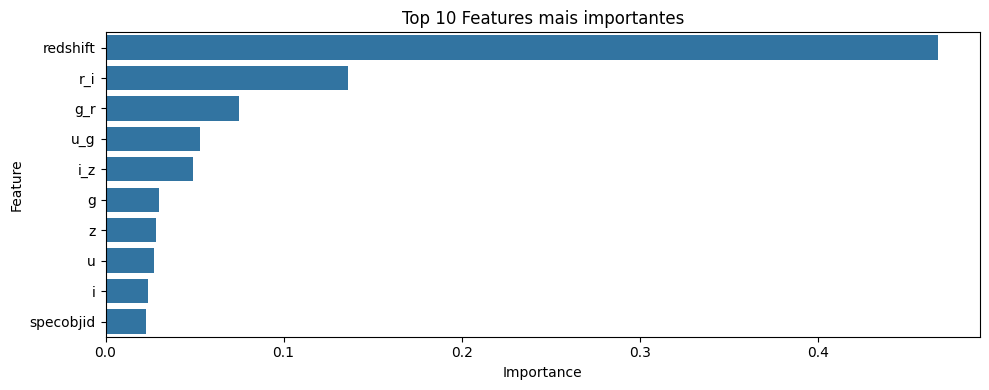

In [0]:
# Criando um dataframe organizado
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizando
plt.figure(figsize=(10, 4))
sns.barplot(data=feat_importance.head(10), x='Importance', y='Feature')
plt.title("Top 10 Features mais importantes")
plt.tight_layout()
plt.show()


In [0]:
# Registrar as 6 features mais importantes + a classe
lista_features = feat_importance.head(6)['Feature'].tolist() + ['class']
print(lista_features)  

# Selecionar features
df = df.select(lista_features)

['redshift', 'r_i', 'g_r', 'u_g', 'i_z', 'g', 'class']


In [0]:
# df spark para df pandas
df_pd = df.toPandas()

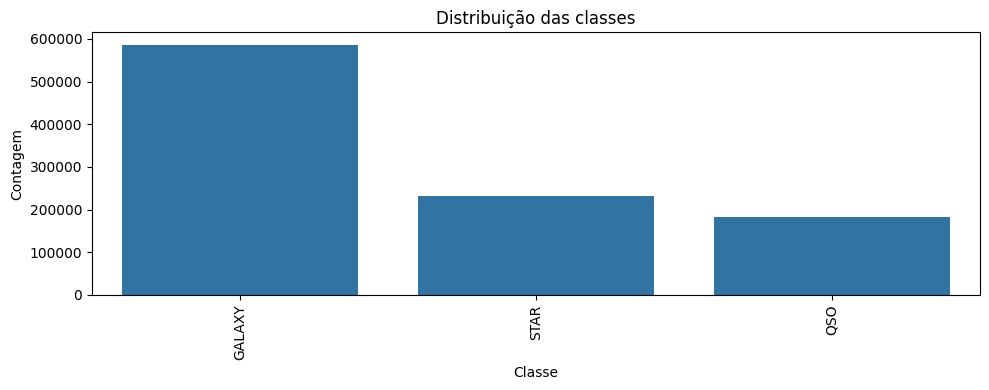

In [0]:
# Ordenar os rótulos da coluna 'subclass' pela contagem (do maior para o menor)
order = df_pd['class'].value_counts().index

# Plot com ordem definida
plt.figure(figsize=(10, 4))
sns.countplot(data=df_pd, x='class', order=order)
plt.title("Distribuição das classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks(rotation=90)  # Roda os rótulos se tiver muitos
plt.tight_layout()
plt.show()

In [0]:
# Separar features e rótulos
X = df_pd.drop("class",axis=1)
y = df_pd["class"]

# Aplicar SMOTE no conjunto de treino para tratar desbalanceamento das classes
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)


#### Salvando em parquet o arquivo balanceado

In [0]:
# Etapa 4: Juntar os dados balanceados
df_smote = pd.concat([X_smote, y_smote], axis=1)

# Converter para pandas e salvar localmente (sem Spark)
caminho_completo_balanceado = pasta_silver + "/" + arquivo_balanceado
print(caminho_completo_balanceado)

# salvar em parquet 
spark.createDataFrame(df_smote)\
        .coalesce(1)\
        .write.mode("overwrite").parquet(caminho_completo_balanceado)


dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/objetos_estelares_balanceado


Distribuição após SMOTE:
 Counter({'GALAXY': 586087, 'QSO': 586087, 'STAR': 586087})




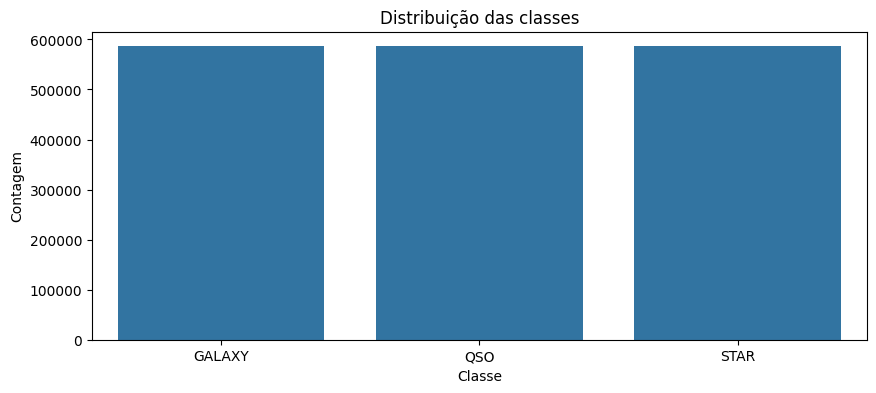

In [0]:
# Ver distribuição das classes codificadas
print("Distribuição após SMOTE:\n", Counter(y_smote))
print("\n")

# Plot codificado
plt.figure(figsize=(10, 4))
sns.countplot(x=y_smote) # seaborn
plt.title("Distribuição das classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

In [0]:
# Contagem do df original antes do balanceamento
df_pd.count()

redshift    999949
r_i         999949
g_r         999949
u_g         999949
i_z         999949
g           999949
class       999949
dtype: int64

In [0]:
# Contagem do df após o balanceamento
df_smote.count()

redshift    1758261
r_i         1758261
g_r         1758261
u_g         1758261
i_z         1758261
g           1758261
class       1758261
dtype: int64